# Starlink and Python: the starlink-pywrapper package.

This notebook illustrates the features and basic usage of the `starlink-pywrapper` package.

Starlink-pywrapper provides wrappers around the normal Starlink packages like KAPPA, CUPID etc, to make them easier to call from python, and so you don't have to use shell escapes in your arguments. It requires you to have a functioning Starlink Software Suite install on your computer and to know where Starlink is located, but it does not require you to run the Starlink setup scripts. It also packages up various parts of the help so that they are easily available within your python session.

This package provides wrappers for the commands in the Starlink packages KAPPA, CUPID, SMURF, POLPACK, PICARD, ATOOLS and FLUXES. There is also an (untested) wrapper around the Starlink Figaro package.


### Links:

http://starlink-pywrapper.readthedocs.io/en/latest/index.html
https://github.com/Starlink/starlink-pywrapper
http://starlink.eao.hawaii.edu



### Dependencies

This package depends on the `starlink-pyhds` package (which  is a low level package that allows you to read and write `.sdf` files within Python), and which itself depends on the `numpy` package. You can install this package and its dependencies with

`pip install starlink-pywrapper`

This package should work in either Python 2.7 or Python 3.5+.

## Contents

1. Setting up the package
1. Differences from standard Starlink
1. Basic usage
1. Getting help with the package
1. More advanced features
1. Running an ORAC-DR Reduction
1. Running many ORAC-DR reductions



## Setting up the package.

First of all, you need to import the package and let it know where Starlink is installed.

In [1]:
from starlink import wrapper

Could not find Starlink: please run change_starpath("/path/to/star")


This warning message just means that I hadn't set the `$STARLINK_DIR` environmental variable, so the wrapper doesn't know where to find your installation of Starlink. If you had set the `$STARLINK_DIR` environmental variable before you started Python, then the wrapper would automatically use that Starlink installation.

We can manually tell the wrapper where Starlink is with:

In [2]:
wrapper.change_starpath('/Users/sarah/star-2017A')

You don't have to reimport the package after changing the `starpath`.

If you ever can't remember which Starlink you are using, look at the `wrapper.starpath`:

In [3]:
print(wrapper.starpath)

/Users/sarah/star-2017A


## Differences from standard Starlink
This wrapper provides pythonic calling of Starlink commands, and is designed primarily for scripting. Therefore it has altered or removed some of the features you may be used to if you are experienced at using the command line Starlink.

1. Using this wrapper, Starlink will **not** remember your previously used values for any of the commands.
1. If using xwindows as a graphic display for the plotting commands (`linplot`, `display` etc), you **have** to give the `device=xw` keyword --  using the `gdset` command and then not giving the `device=` keyword will not work.
1. For keyword arguments, you have to give the full keyword name (shortening to a unique value isn't possible in this wrapper)
1. Starlink will not prompt you if you forget a keyword argument that is needed, the command will instead fail with an error.


### Unexpected *features* if you're used to Python

The way in which Starlink calls commands is very different from Python. The package attempts to neatly divide all the possible arguments for a command into `required` positional arguments and `optional` keyword arguments. However, often you will **have** to give some of the keyword arguments to run the command successfully. Hopefully the documentation on each command should make this clear. Occasionally there will be a required argument that you don't actually need -- normally you can safely give any value to these without causing any problems.

It is possible that the automatic generator script that creates the documentation and call signatures for the commands could have a bug such that the resulting `starlink-pywrapper` command cannot work succesfully. If you run into any issue like this, please let me know so I can fix this (s.graves AT eaobservatory.org).

## Basic usage of the commands.

The commands should be called like normal python functions. For example, to call the KAPPA `stats` function you would run (replace  `'../Starlink_Analysis/scuba2_map.sdf'` with a path to an NDF file on your own machine):

In [4]:
from starlink import kappa
file =  '../Starlink_Analysis/scuba2_map.sdf'
statsvals = kappa.stats(file)
print(statsvals)

 numgood    39948
  numbad    18133
   order    False
kurtosis    1147.2814951588975
   sigma    887.2211091888624
    mean    95.57703057878183
  maxpos    [0, 0, 1]
   total    3818111.2175611774
     ndf    ../Starlink_Analysis/scuba2_map.sdf
 minimum    -800.1018996019743
maxcoord    [-1.3381681735838045, 0.021788981266010584, 0.00085]
skewness    29.107865318223343
  numpix    58081
mincoord    [-1.3361896752346525, 0.02159501271504439, 0.00085]
  minwcs    18:53:46.073, 1:14:14.29, 0.00085
    comp    DATA
 maximum    48378.649881284786
  maxwcs    18:53:18.867, 1:14:54.30, 0.00085
  minpos    [-102, -10, 1]


Commands are easily called as `<package>.<commandname>(arguments, keyword1=...)`

Required (positional) arguments can be given either by position as above  or you can use the full name and pass the value as if it was a keyword. For example, you can pass the value `file` to the`ndf` argument of `kappa.stats` in either of these two ways:

In [5]:
statsvals = kappa.stats(file)
statsvals = kappa.stats(ndf=file)

(Although it takes more typing, for complex command calls it is often clearer when you look back at a script if you use the second appraoch and give the argument name before each argument.)

Optional (keyword) arguments are listed in the inline help (see the section `Getting help with the package` below), and are passed like normal Python keyword arguments. For example, the `order` and `comp` options can be changed from their defaults like:

In [6]:
statsvals = kappa.stats(file, order=True, comp='ERROR')
print(statsvals)

 numgood    39948
  numbad    18133
  median    21.865963058563082
   order    True
kurtosis    26.029946463873603
   sigma    50.65975753759802
    mean    41.05555477058478
  maxpos    [-13, 122, 1]
   total    1640087.3019753105
     ndf    ../Starlink_Analysis/scuba2_map.sdf
 minimum    10.638659143775554
maxcoord    [-1.337915996605891, 0.024154866836891307, 0.00085]
skewness    3.9059048292368095
  numpix    58081
mincoord    [-1.33810998137446, 0.022235009763934978, 0.00085]
  minwcs    18:53:19.667, 1:16:26.30, 0.00085
    comp    ERROR
 maximum    1157.3041341557991
  maxwcs    18:53:22.334, 1:23:02.30, 0.00085
  minpos    [-3, 23, 1]


### Returned values

The return object is a [`namedtuple`](https://docs.python.org/3/library/collections.html#collections.namedtuple) instance. The values in the object are automatically populated from the values written into the `$ADAM_DIR/<commandname>.sdf` parameter file. If you have used the `parget` command in Starlink to programmatically get return values this should be familiar to you -- the names will be the same.

You access fields in the output value as attributes:


In [7]:
print(statsvals.median, type(statsvals.median))

21.865963058563082 <class 'numpy.float64'>


To see the full list of fields programmatically, you can look at the `returnval._fields` object:

In [8]:
print(statsvals._fields)

('numgood', 'numbad', 'median', 'order', 'kurtosis', 'sigma', 'mean', 'maxpos', 'total', 'ndf', 'minimum', 'maxcoord', 'skewness', 'numpix', 'mincoord', 'minwcs', 'comp', 'maximum', 'maxwcs', 'minpos')


This return value lets you use the calculated values of Starlink commands in your scripts.

Commands that primarly produce an output file rather than calculate values may not write anything very interesting to the return value; often it will just repeat the values of the parameters you set (and the default paramters you didn't give) from the command line call. For example, if we look at the output of  CONVERT's NDF2FITS command:

In [9]:
from starlink import convert

a = convert.ndf2fits(in_=file, out='!scuba2_map.fits')
print(a)

  checksum    True
   profits    True
       in_    ../Starlink_Analysis/scuba2_map.sdf
    duplex    False
    prohis    True
provenance    None
   proexts    False
       out    !scuba2_map.fits
    bitpix    0
  encoding    Auto
      comp    A
    native    False
  allowtab    True
 container    False


Unfortunately the `a.out` value is exactly as you passed the filename to `out` in the function call -- it does not represent the newly written file name itself. Here, the function call had a prepended exclamation mark, which allows you to overwrite a FITS file of the same name. The produced file on disk does not have that exclamation mark, but this is not shown to you in the `a.out` value.

In [10]:
import os
print(os.path.isfile(a.out), os.path.isfile('scuba2_map.fits'))

False True


You can also see that the parameter name 'in' from Starlink has been translated to `in_` for the Python wrapper; this is because `in` is a Python reserved name, so it has had an underscore attached to its name.

## Getting help with the package

This package attempts to bundle some of the most useful help with the package. You can see a short summary of a command and its python call signature and allowed keywords with the normal Python `help` function, or with the jupyter magic command `modulename.commandname?`. These are intended to be of use when you are running interactive sessions, either in the terminal or in the notebook.

In [11]:
from starlink import kappa, cupid
help(kappa.add)

Help on function add in module starlink.kappa:

add(in1, in2, out, **kwargs)
    Adds two NDF data structures.
    
    Runs the command: $KAPPA_DIR/add .
    
    Arguments
    ---------
    in1 : str,filename
        First input NDF
    
    in2 : str,filename
        Second input NDF
    
    out : str,filename
        Output NDF
    
    
    Keyword Arguments
    -----------------
    title : str
        Title for output NDF [!]
    
    
    Notes
    -----
    See http://www.starlink.ac.uk/cgi-bin/htxserver/sun95.htx/sun95.html?xref_ADD
    for full documentation of this command in the latest Starlink release



At the end of the help it should include a URL taking you to the full Starlink documentation of this command (not specific to using Python to call it.) This will include a lot more detail on the command and its options.

You can also see the module help -- this will include the version of starlink these wrappers were generated for, as well as the help (same as above) on all the commands in the module. Warning: this is very long.

In [12]:
help(cupid)

Help on module starlink.cupid in starlink:

NAME
    starlink.cupid - Runs commands from the Starlink CUPID package.

DESCRIPTION
    Autogenerated from the starlink .hlp and .ifl files,
    by starlink-pywrapper/helperscripts/generate_functions.py.
    
    Starlink version: 2017A
    bfdc8534a17c406c59302030ed1c1ae1a1223bd1 (2017-07-28 09:12:59)

FUNCTIONS
    clumpinfo(ndf, **kwargs)
        Obtain information about one or more previously identified clumps.
        
        Runs the command: $CUPID_DIR/clumpinfo .
        
        Arguments
        ---------
        ndf : str,filename
            Input NDF containing clump identifications
        
        
        Keyword Arguments
        -----------------
        clumps : str
            The indices of the clumps to use [ALL]
        
        quiet : bool
            Supress screen output? [FALSE]
        
        
        Returns
        -------
        flbnd : List[float]
        
        fubnd : List[float]
        
        lbo

In order to make it easier to see what is available in a module, the package contains a `starhelp` command in the `utilities` subpackage. If you call this on a module this will show you a listing of all the commands available in that module, along with a short one line description of what it does.

In [13]:
from starlink.utilities import starhelp
starhelp(cupid)

clumpinfo     :     Obtain information about one or more previously identified clumps.
cupidhelp     :     Display information about CUPID.
extractclumps :     Extract previously identified clumps of emission from an NDF.
findback      :     Estimate the background in an NDF by removing small scale structure.
findclumps    :     Identify clumps of emission within a 1, 2 or 3 dimensional NDF.
makeclumps    :     Create simulated data containing clumps and noise.
outlineclump  :     Draw an outline around a 2-dimensional clump identified by CUPID.

If you call `starhelp` on a command, it will show you the **full** documentation of this Starlink command (not specific to this python wrapper) in .rst format. It will probably be better to look at the normal online Starlink documentation instead (linked at the end of the output seen running a normal `help` or `?` on a command).

In [14]:
starhelp(kappa.add)



ADD
===


Purpose
~~~~~~~
Adds two NDF data structures


Description
~~~~~~~~~~~
The routine adds two NDF data structures pixel-by-pixel to produce a
new NDF.


Usage
~~~~~


::

    
       add in1 in2 out
       



ADAM parameters
~~~~~~~~~~~~~~~



IN1 = NDF (Read)
````````````````
First NDF to be added.



IN2 = NDF (Read)
````````````````
Second NDF to be added.



OUT = NDF (Write)
`````````````````
Output NDF to contain the sum of the two input NDFs.



TITLE = LITERAL (Read)
``````````````````````
Value for the title of the output NDF. A null value will cause the
title of the NDF supplied for parameter IN1 to be used instead. [!]



Examples
~~~~~~~~
add a b c
This adds the NDF called b to the NDF called a, to make the NDF called
c. NDF c inherits its title from a.
add out=c in1=a in2=b title="Co-added image"
This adds the NDF called b to the NDF called a, to make the NDF called
c. NDF c has the title "Co-added image".



Notes
~~~~~


+ The output NDF contains the simple su

## More advanced features.

### Accessing the terminal output

If you've previously only examined the output of Starlink commands by reading or grepping the output written to the terminal, hopefully the return values shown here will be useful. Generally, you should not need to grep the string output of a Starlink command.


However, particularly while you are developing your script you may still sometimes want to see with the *normal* output, so this module does provide a means of doing that. The simplest way is to turn the standard python logging module into DEBUG mode. When you do that, the module will write both the full Starlink command it is running (useful if you run into problems) as well as the normal terminal output you would see if you ran this on the command line. For example, if you turn on DEBUG logging and run the `kappa.stats` command you will see:

In [15]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.root.setLevel(logging.DEBUG)

statsvals = kappa.stats(ndf=file, order=True, comp='ERROR')

DEBUG:starlink.wrapper:['/Users/sarah/star-2017A/bin/kappa/stats', '../Starlink_Analysis/scuba2_map.sdf', 'comp=ERROR', 'order=True']
DEBUG:starlink.wrapper:
   Pixel statistics for the NDF structure /Users/sarah/SeoulUsersMeeting/Tutorials/../Starlink_Analysis/scuba2_map

      Title                     : G34.3
      NDF array analysed        : ERROR

         Pixel sum              : 1640087.30197531
         Pixel mean             : 41.0555547705848
         Standard deviation     : 50.659757537598
         Skewness               : 3.90590482923681
         Kurtosis               : 26.0299464638736
         Minimum pixel value    : 10.6386591437756
            At pixel            : (-3, 23, 1)
            Co-ordinate         : (18:53:19.667, 1:16:26.30, 0.00085)
         Maximum pixel value    : 1157.3041341558
            At pixel            : (-13, 122, 1)
            Co-ordinate         : (18:53:22.334, 1:23:02.30, 0.00085)
         Pixel median           : 21.8659630585631
     

To turn this back to only showing INFO level logging information, you would run (in a jupyter notebook):

In [16]:
logging.root.setLevel(logging.INFO)

In a normal Python script or interactive session (not a jupyter notebook) you would normally run
```python
import logging
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
```

#### Accessing the Standard Output as a string
Sometimes you may want to get the output that is normally written to the terminal as a string. You shouldn't normally need this, but if you do then pass the keyword argument `returnstdout=True` to any of the Starlink commands.

In [17]:
statsvals, stdout = kappa.stats(ndf=file, order=True, comp='ERROR', returnstdout=True)
print(stdout)


   Pixel statistics for the NDF structure /Users/sarah/SeoulUsersMeeting/Tutorials/../Starlink_Analysis/scuba2_map

      Title                     : G34.3
      NDF array analysed        : ERROR

         Pixel sum              : 1640087.30197531
         Pixel mean             : 41.0555547705848
         Standard deviation     : 50.659757537598
         Skewness               : 3.90590482923681
         Kurtosis               : 26.0299464638736
         Minimum pixel value    : 10.6386591437756
            At pixel            : (-3, 23, 1)
            Co-ordinate         : (18:53:19.667, 1:16:26.30, 0.00085)
         Maximum pixel value    : 1157.3041341558
            At pixel            : (-13, 122, 1)
            Co-ordinate         : (18:53:22.334, 1:23:02.30, 0.00085)
         Pixel median           : 21.8659630585631
         Total number of pixels : 58081
         Number of pixels used  : 39948 (68.8%)
         No. of pixels excluded : 18133 (31.2%)




This causes the command to return a tuple of the normal returned object and the Starlink terminal output as a string.


### Shell Escapes
Shell escapes are the sets of quotes or backslashes that you have to use when running Starlink in a shell if you have any special characters in your command line call -- they `escape` you from the shell's attempt to interpret those charaters.

Unlike when you call Starlink commands directly in your terminal, this python wrapper doesn't go through a shell, so you do not have to use shell escapes around string values. For example, when providing an NDF section to only include a 6 by 6 pixel square of your map you would do:

In [18]:
# No need to use shell escapes! E.g., if you want to pass an ndfsection you can do
section = '(0:5,0:5)'
statsvals = kappa.stats(ndf=file+section, comp='ERROR')
print(statsvals)
print(statsvals.ndf)

 numgood    36
  numbad    0
   order    False
kurtosis    -0.8029823301673149
   sigma    43.44768072049565
    mean    56.78561067384343
  maxpos    [1, 0]
   total    2044.2819842583647
     ndf    ../Starlink_Analysis/scuba2_map.sdf(0:5,0:5)
 minimum    15.635780592588478
maxcoord    [-1.3381875707353537, 0.02178898127010817, 0.00085]
skewness    0.8710338530851028
  numpix    36
mincoord    [-1.338265159505499, 0.02188594394031615, 0.00085]
  minwcs    18:53:17.533, 1:15:14.30, 0.00085
    comp    ERROR
 maximum    145.2239807802179
  maxwcs    18:53:18.600, 1:14:54.30, 0.00085
  minpos    [5, 5]
../Starlink_Analysis/scuba2_map.sdf(0:5,0:5)


as opposed to running in your terminal, where you have to do:
```bash
stats "'../Starlink_Analysis/scuba2_map.sdf(0:5,0:5)'"
# or
stats ../Starlink_Analysis/scuba2_map.sdf\(0:5,0:5\)
```

Unfortunately you still can't include spaces in your NDF section (you also can't on the command line).

In [19]:
section = '(0:5, 0:5)'
statsvals = kappa.stats(ndf=file+section, comp='ERROR')

Exception: Starlink error occured during command:
/Users/sarah/star-2017A/bin/kappa/stats ('../Starlink_Analysis/scuba2_map.sdf(0:5, 0:5)',)
 stdout and stderr are appended below.
!! GRP1_PAREL: Un-matched delimiters '()' found in
!     '../Starlink_Analysis/scuba2_map.sdf(0:5,'.
!  GRP_GRPEX: Unable to read names from group expression
!     ../Starlink_Analysis/scuba2_map.sdf(0:5,
!  Error obtaining a group of existing NDFs using group expression
!     "../Starlink_Analysis/scuba2_map.sdf(0:5,"
!  Unable to associate a group of NDFs with parameter NDF.
!  STATS: Error computing simple statistics for an NDF's pixels.
!  Application exit status GRP__INVEL, Invalid element syntax given
!  ../Starlink_Analysis/scuba2_map.sdf(0:5, 0:5) comp=ERROR



### Error handling
The above example illustrates error handling. As well as the normal Python traceback seen at the top of the screen, you should also be shown the Starlink command that was run, its arguments, and the actual Starlink-generated error message. In this case, if you read the message you can see that it is trying to evaluate `'Starlink_Analysis/scuba2_map.sdf(0:5,'` as an NDF section, and of course failing. This is because the space we included in the NDF section causes Starlink to break the parameter at that point.

You can use normal Python exception handling to deal with these Starlink errors, in a normal ```try ... except ...``` block.

Currently ORAC-DR calls through `wrapper.oracdr` (see below) don't raise an error when they have problems; instead they produce a return value. This will probably be changed in the next version of the code.

## Running an ORAC-DR reduction

The `starlink.wrapper` module includes a function to help you script ORAC-DR reductions from Python scripts. Although this may seem a little unnecessary (ORAC-DR is itself a script running Starlink commands from Perl), we've found quite a few JCMT users need to script ORAC-DR reductions. Often, people need to tweak some of the configuration options for ORAC-DR, and being able to easily re-run their whole reduction with only one thing changed, or being able to run through a pre-defined matrix of different options (recipes, recipe parameters, or even input data) to compare the outputs is required.

The ORAC-DR implementation is a bit cruder than some other parts -- I'm not intending on changing the call signature, but we could conceivably provide more specific, wrapped functions to call specific reduction recipes in the future. Let us know if this sounds like it could be useful!

The function to run ORAC-DR is called `oracdr` and is inside the `starlink.wrapper` module:

In [20]:
from starlink import wrapper
help(wrapper.oracdr)

Help on function oracdr in module starlink.wrapper:

oracdr(instrument, loop='file', dataout=None, datain=None, recipe=None, recpars=None, onegroup=False, rawfiles=None, utdate=None, obslist=None, headeroverride=None, calib=None, verbose=False, debug=False, warn=False)
    Run oracdr on a batch of files.
    
    Arguments
    ---------
    instrument: str
        Name of instrument
    
    Keyword Arguments
    -----------------
    
    loop: str
      'file' or 'list'. determine if input obs are specified as
      raw file names/paths or as a list of observation numbers and a
      utdate. ['file']
    
    dataout: str
       Location of output data directory; defaults to current dir.
    
    datain: str
       Location of input data; defaults to current dir.
    
    recipe str:
       Name of recipe to run. If None, use recipe from headers.
    
    recpars str:
       Value to pass as a recipe parameter option -- either a filename
       or the recpars themselves.
    
    one

The most important parameters for most users are probably the `instrument`, `rawfiles`, `recipe` and `recpars` options.

The return values from an ORAC-DR run are quite different from other commands in this module: it will give you an object with attributes telling you where the output logfile is (very useful to see what happened), the output directory, lists of data, image and log files produced at the end of the output, the status code and the pid of the Perl process that ran ORAC-DR.

#### Differences from the stand-alone ORAC-DR.
ORAC-DR was designed to write information to index files when it is run in a specific directory, and read that information back in if it is run in the same directory, allowing it to do things like turn off detectors that it already knows will fail QA etc. Although this behaviour is very powerful and vital for some use cases, it also causes problems when scripting JCMT data, especially when you want to run some data through a variety of DR recipes, changing various DR and QA parameters to see what effect they have etc.

I've also seen several people accidentally write over their previous DR runs by changing to a new directory, but forgetting to change the `ORAC_DATAOUT` environmental variable.

To avoid this, this wrapper **always** runs ORAC-DR in a new, unique, directory created in the directory specified as `dataout=`. The directory name is returned to the user in the output value. It is up to the user to clear up these output directories if needed. 

If the original behaviour is needed, a future version of this module could add a keyword argument reverting to the default non-python ORAC-DR behaviour (and defaulting to False).

### The main parameters:

#### `instrument`

This has to be provided. The available options are in: `wrapper.JCMTINST`.

In [21]:
print(wrapper.JCMTINST)

['ACSIS', 'SCUBA2_850', 'SCUBA2_450', 'SCUBA', 'JCMTDAS']


#### `files=`  parameter: methods of specifying the input files:

Normally you will be providing a list of files. You can provide this by first creating a textfile listing each raw filename on a new line (with either a full path or the path relative the `datain` directory), and then you pass this filename in as a string like `rawfiles='myfile.lis'`. Alternatively, you can pass in a Python list object, where each entry is a string giving the absolute or relative path of a raw file. 

####  `recipe=` : selecting a different recipe
If you want to use a recipe other than the default value set in the `RECIPE` FITS header of your raw data, then you would pass its full name to the `recipe=` keyword argument.

#### `recpars=`: specifying recipe parameters
Recipe parameters are the normal way of altering the behaviour of an ORAC-DR recipe. Please see the ORAC-DR documentation to see the available recipe parameters. You normally provide them via a text file, and then you simply pass the text file name and path to this option (as a string).


### Handling errors

Currently (and this will change in the future), this command doesn't raise an exception of ORAC-DR ends with an error. You'll need to manually look at the returned status int, and/or read the log file to see what happened.

### Example usage
Here is a simple example, where some data files are passed as a Python list to ORAC-DR. The instrument is set, and it then runs the chosen recipe ('REDUCE_SCAN') on that data. If you are running this in a jupyter notebook, then normal ORAC-DR terminal output is shown in the terminal where you started the jupyter process (sorry!).

This example uses the raw files provided by the SCUBA-2  Tutorial, and to speed things up, is only using the 's8a' subarray. It takes ~2 or 3 minutes to run on a 2013 Mac laptop with 4GB of RAM.

In [22]:
import glob
import os

rawdatapath = '../SCUBA2_tutorial/raw/'


files = glob.glob(os.path.join(rawdatapath, 's8a20120501_00068*.sdf'))
print(files)

output = wrapper.oracdr('SCUBA2_850', loop='file', dataout='.', 
                        recipe='REDUCE_SCAN', rawfiles=files)

INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lisgtzgpgzn REDUCE_SCAN.


['../SCUBA2_tutorial/raw/s8a20120501_00068_0001.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0002.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0003.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0004.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0005.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0006.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0007.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0008.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0009.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0010.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0011.sdf', '../SCUBA2_tutorial/raw/s8a20120501_00068_0012.sdf']


#### The returned output
`output` holds various information about the run.

In [23]:
print(output._fields)

('runlog', 'outdir', 'datafiles', 'imagefiles', 'logfiles', 'status', 'pid')


`output.runlog`: This gives the full path location of the logfile for this ORAC-DR run. This file is inside the ORAC working directory for this call of `wrapper.oracdr`.

In [24]:
print(output.runlog)

/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/oracdr_84575.log


`output.outdir`: This gives the full path of the temporary working directory where all the output files are written: the ORAC_DATA_OUT location. This is unique for each call of `wrapper.oracdr`.

In [25]:
print(output.outdir)

/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw


`output.datafiles`: This gives the full list of `.sdf` files produced by this ORAC-DR call. Please note that it will sometimes include files that should ahve been cleaned out by ORAC-DR: e.g. t3270.sdf or similar. These can be safely ignored.

In [26]:
output.datafiles

['/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/gs20120501_68_850_reduced.sdf',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/s20120501_00068_850_reduced.sdf',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/gs20120501_68_850_catalog.FIT']

`output.imagefiles`: The full list of `.png` files (normally preview images) produced by this ORAC-DR call.

In [27]:
output.imagefiles

['/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/gs20120501_68_850_reduced_1024.png',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/gs20120501_68_850_reduced_256.png',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/gs20120501_68_850_reduced_64.png',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/s20120501_00068_850_reduced_1024.png',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/s20120501_00068_850_reduced_256.png',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/s20120501_00068_850_reduced_64.png']

`output.logfiles`: Any `log.*` files produced.

In [28]:
output.logfiles

['/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.group',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.mapstats',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.nefd',
 '/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.noise']

You can read these in with the astropy table module. Unfortunately the 'log.group' default files require different means of reading in.

In [29]:
from astropy.table import Table
groupfile = [i for i in output.logfiles if i.endswith('log.group')][0]
otherlogs = [i for i in output.logfiles if not i.endswith('log.group')]
group = Table.read(groupfile, format='ascii.commented_header')
print(groupfile)
print(group, '\n')
for i in otherlogs:
    print(i)
    print(Table.read(i, format='ascii.commented_header', header_start=3),'\n')


/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.group
Group          File         
----- ----------------------
   68 s8a20120501_00068_0001
   68 s8a20120501_00068_0002
   68 s8a20120501_00068_0003
   68 s8a20120501_00068_0004
   68 s8a20120501_00068_0005
   68 s8a20120501_00068_0006
   68 s8a20120501_00068_0007
   68 s8a20120501_00068_0008
   68 s8a20120501_00068_0009
   68 s8a20120501_00068_0010
   68 s8a20120501_00068_0011
   68 s8a20120501_00068_0012 

/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.mapstats
       UT                HST         ...    recipe             filename         
---------------- ------------------- ... ----------- ---------------------------
20120501.6984144 2012-05-01T06:45:43 ... REDUCE_SCAN s20120501_00068_850_reduced 

/Users/sarah/SeoulUsersMeeting/Tutorials/ORACworkingxb5olxxw/log.nefd
       UT                HST         Obs Source ... Effective_NEFD Nbol Method
---------------- ------------------- --- ------ ... -

`output.status`: <int>, the return status of the ORAC-DR run. If there were no errors, then this will be 0. If it is not 0, please check the `output.runlog` file to see what went wrong.
    

In [30]:
print(output.status)

0


`output.pid`: the process id of the ORAC-DR run (not normally needed.)

In [31]:
print(output.pid)

84575


## Advanced ORAC-DR scripting: iterating through options.

Here is a couple of brief snippets illustarting a (hopefully) relevant DR process: reducing a series of data through a variety of ORAC-DR options (here pixelnsize), and through two ORAC-DR recipes.

### First get the list of files:

This assumes you have a single file listing the utdate/observation combo you want to get, and a path that contains the downloaded data from CADC. We will use this to assemble a Python list of raw data files. This example uses data from the SCUBA-2 tutorial, but you could replace this with any SCUBA-2 raw data you have on your machine (or ACSIS data if you change the rawfile match below).

In [32]:
# Write our observation dates and obsnums to a file.
# Normally you would have many, here we only have one observation.
f = open('observation.lis' , 'w')
f.write('20120501, 68\n')
f.close()


#patternmatch: this is a string that can be formatted with a date and year
# ({} indicate something which will be formatted), and will then match SCUBA-2 file names.
# {:d} This will be formated with the YYYYMMDD as an integer
# {:05d} Format the observation number, padded to 5 digits with zeros.
# [0-9] Match any digit from 0 to 9
s2850_rawfile_match = 's8a{:d}_{:05d}_[0-9][0-9][0-9][0-9].sdf'


# If you have a more powerful computer, match all the files instead of only subarray by uncommenting the line below:
# s2850_rawfile_match = 's8[a-d]{:d}_{:05d}_[0-9][0-9][0-9][0-9].sdf'

path='../SCUBA2_tutorial/raw/'
inputfiles = []
f = open('observation.lis', 'r')

for line in f:
    utdate, obsnum = line.strip().split(', ')
    utdate = int(utdate)
    obsnum = int(obsnum)
    filematch = s2850_rawfile_match.format(utdate, obsnum)
    inputfiles += glob.glob(os.path.join(path, filematch))
f.close()

inputfiles

['../SCUBA2_tutorial/raw/s8a20120501_00068_0001.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0002.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0003.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0004.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0005.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0006.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0007.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0008.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0009.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0010.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0011.sdf',
 '../SCUBA2_tutorial/raw/s8a20120501_00068_0012.sdf']

### Run files through repeated ORAC-DR

We're now going to run those observations through ORAC-DR. However, we're going to imagine that these are from a new project, and we aren't quite sure yet how we want to reduce them. We're going to iterate through both two recipes and 3 different pixel sizes.

This example will show you how to give recpars as a string: you can also write them to a Recipe Parameter text file (which can have different options for  different sources/ frequencies / etc, allowing you to use a single file across your entire project.)

**Be warned, this runs ORAC-DR on the observation files above 6 times, so it will take around 10-15 minutes to run**

In [33]:
# Recipes we want to try.
recipes = ['REDUCE_SASSY', 'REDUCE_SCAN']

# Pixel sizes we want to try
pixelsizes = [4.0,6.0,8.0]


# Create a list object to hold the output variable from each ORAC-DR run.
outputs = []

# Now iterate over both the recipes and the pixelsizes:
for recipe in recipes:
    for pixsize in pixelsizes:
        print('RECIPE %s, Pixel size %d'%(recipe, pixsize))

        # Use a sensibly named outputdir -- not necessarily required, as wrapper.oracdr will write
        # each reduction into a unique directory inside the output directory anyway
        outputdir = 'testing-{}-pixsize-{}'.format(recipe, str(pixsize).replace('.','_'))
        if not os.path.isdir(outputdir):
            os.mkdir(outputdir)

        # Create the recipe parameter  option as a single string passed to the call instead of writing to a file.
        # -- note the format doesn't require shell escapes in this wrapper.
        recpar_string = 'MAKEMAP_PIXSIZE={}'.format(pixsize)
        
        # Call ORAC-DR with these options.
        output = wrapper.oracdr('SCUBA2_850', rawfiles=inputfiles,
                                dataout=outputdir, recipe=recipe, recpars=recpar_string,verbose=True,debug=True)
        
        # Save the output information to our outputs list.
        outputs.append(output)


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lis5b3x1k8k -recpars=MAKEMAP_PIXSIZE=4.0 -verbose -debug REDUCE_SASSY.


RECIPE REDUCE_SASSY, Pixel size 4


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lissqe97gyg -recpars=MAKEMAP_PIXSIZE=6.0 -verbose -debug REDUCE_SASSY.


RECIPE REDUCE_SASSY, Pixel size 6


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lisqa9biwm0 -recpars=MAKEMAP_PIXSIZE=8.0 -verbose -debug REDUCE_SASSY.


RECIPE REDUCE_SASSY, Pixel size 8


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lisdltp81sn -recpars=MAKEMAP_PIXSIZE=4.0 -verbose -debug REDUCE_SCAN.


RECIPE REDUCE_SCAN, Pixel size 4


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lis8pazo15h -recpars=MAKEMAP_PIXSIZE=6.0 -verbose -debug REDUCE_SCAN.


RECIPE REDUCE_SCAN, Pixel size 6


INFO:starlink.wrapper:Keyword Argument datain was not given, so defaulting to .
INFO:starlink.wrapper:Setting ORAC_DATA_IN to .
INFO:starlink.wrapper:Running /Users/sarah/star-2017A/Perl/bin/perl /Users/sarah/star-2017A/bin/oracdr/src/bin/oracdr -log=sf -nodisplay -batch -loop=file -files=/var/folders/m7/9t920hrs781_77x_81358trr0000gn/T/tmpORACInputList.lis8k3pg0n8 -recpars=MAKEMAP_PIXSIZE=8.0 -verbose -debug REDUCE_SCAN.


RECIPE REDUCE_SCAN, Pixel size 8


All the files are stored inside various uniquely-named directories, like so:

In [34]:
outputs[0].outdir

'/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SASSY-pixsize-4_0/ORACworkingk_6_9641'

If we want to keep the output files, we might move them out of the ORACworking* directories and into the normal working directories. (This wrapper puts everything into seperate directories to avoid repeated runs overwriting the same files. )

The image files ORAC-DR produces are stored in the `outout.imagefiles` attribute, and its fairly easy to grab only group coadds of a specific size with a **conditional list comprehension**; you could also use a for loop if you prefer.

In [35]:
imagefiles1024 = [i for i in outputs[0].imagefiles if os.path.split(i)[1].startswith('g') and i.endswith('1024.png')]
imagefiles1024

['/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SASSY-pixsize-4_0/ORACworkingk_6_9641/gs20120501_68_850_reduced_1024.png']

You can then either save the list of images to look at in your chosen image viewing program, or if you are working in a jupyter notebook like here display them as:

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SASSY-pixsize-4_0/ORACworkingk_6_9641/gs20120501_68_850_reduced_256.png


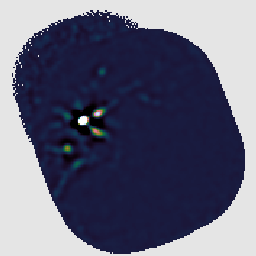

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SASSY-pixsize-6_0/ORACworkingyl0uovcm/gs20120501_68_850_reduced_256.png


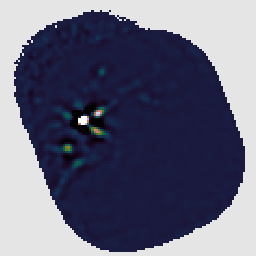

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SASSY-pixsize-8_0/ORACworkingvg4h0_n0/gs20120501_68_850_reduced_256.png


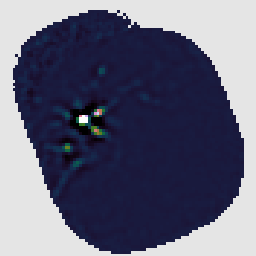

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SCAN-pixsize-4_0/ORACworkingjahonuk4/gs20120501_68_850_reduced_256.png


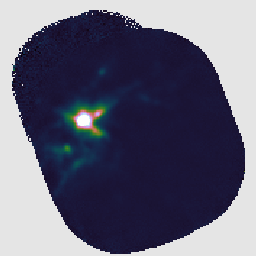

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SCAN-pixsize-6_0/ORACworkingxlsz3mgj/gs20120501_68_850_reduced_256.png


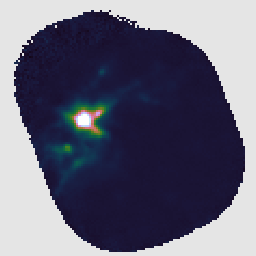

/Users/sarah/SeoulUsersMeeting/Tutorials/testing-REDUCE_SCAN-pixsize-8_0/ORACworking5kel4c1o/gs20120501_68_850_reduced_256.png


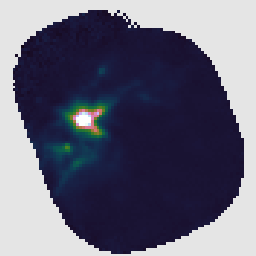

In [36]:
from IPython.display import Image, display
images_to_show = []
for o in outputs:
    imagefiles = [i for i in o.imagefiles if os.path.split(i)[1].startswith('g') and i.endswith('256.png')]
    print(imagefiles[0])
    display(Image(imagefiles[0]))

## A couple of useful extras inside starlink-pywrapper


### Accessing the FITS header
There is a utility function in the `starlink.utilities` module which will read in the FITS headers of an NDF file and convert it into an Astropy `fitsheader` object. This requires the `astropy` package to be installed and available to Python. It is used as:

In [37]:
from starlink.utilities import get_ndf_fitshdr
fitsheader = get_ndf_fitshdr('../Starlink_Analysis/scuba2_map.sdf')
fitsheader

TELESCOP= 'JCMT    '           / Name of Telescope                              
ORIGIN  = 'Joint Astronomy Centre, Hilo' / Origin of file                       
                                                                                
        ---- x,y,z triplet for JCMT relative to centre of earth ----            
ALT-OBS =               4120.0 / [m] Height of observatory above sea level      
LAT-OBS =      19.822838905884 / [deg] Latitude of Observatory                  
LONG-OBS=    -155.477027838737 / [deg] East longitude of observatory            
OBSGEO-X=    -5464587.04742954 / [m]                                            
OBSGEO-Y=    -2492998.88150847 / [m]                                            
OBSGEO-Z=     2150659.39661545 / [m]                                            
ETAL    =                 0.85 / Telescope efficiency                           
                                                                                
        ---- OMP and ORAC-DR

### Using PICARD

Picard recipes are also available, either in the same way as ORAC-DR via `wrapper.picard`, or wrapped up for each recipe as

In [38]:
from starlink import picard
starhelp(picard)

calc_scuba2_avpspec      : Run PICARD'S CALC_SCUBA2_AVPSPEC recipe.
calc_scuba2_fcf          : Run PICARD'S CALC_SCUBA2_FCF recipe.
calc_scuba2_nefd         : Run PICARD'S CALC_SCUBA2_NEFD recipe.
calibrate_scuba2_data    : Run PICARD'S CALIBRATE_SCUBA2_DATA recipe.
coadd_jsa_tiles          : Run PICARD'S COADD_JSA_TILES recipe.
create_moments_map       : Run PICARD'S CREATE_MOMENTS_MAP recipe.
create_png               : Run PICARD'S CREATE_PNG recipe.
crop_scuba2_images       : Run PICARD'S CROP_SCUBA2_IMAGES recipe.
estimate_image_alignment : Run PICARD'S ESTIMATE_IMAGE_ALIGNMENT recipe.
jsa_catalogue            : Run PICARD'S JSA_CATALOGUE recipe.
mosaic_jcmt_images       : Run PICARD'S MOSAIC_JCMT_IMAGES recipe.
picard_demonstrator      : Run PICARD'S PICARD_DEMONSTRATOR recipe.
scuba2_check_cal         : Run PICARD'S SCUBA2_CHECK_CAL recipe.
scuba2_check_rms         : Run PICARD'S SCUBA2_CHECK_RMS recipe.
scuba2_display_pca       : Run PICARD'S SCUBA2_DISPLAY_PCA recipe.
scuba2_ja

The command line calls are very similar to that of the `oracdr` command.